In [1]:
import dgl
import dgl.function as fn
import torch 
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import json
import import_ipynb
from resnet import resnet34_other,resnet50,resnet101

Using backend: pytorch


importing Jupyter notebook from resnet.ipynb


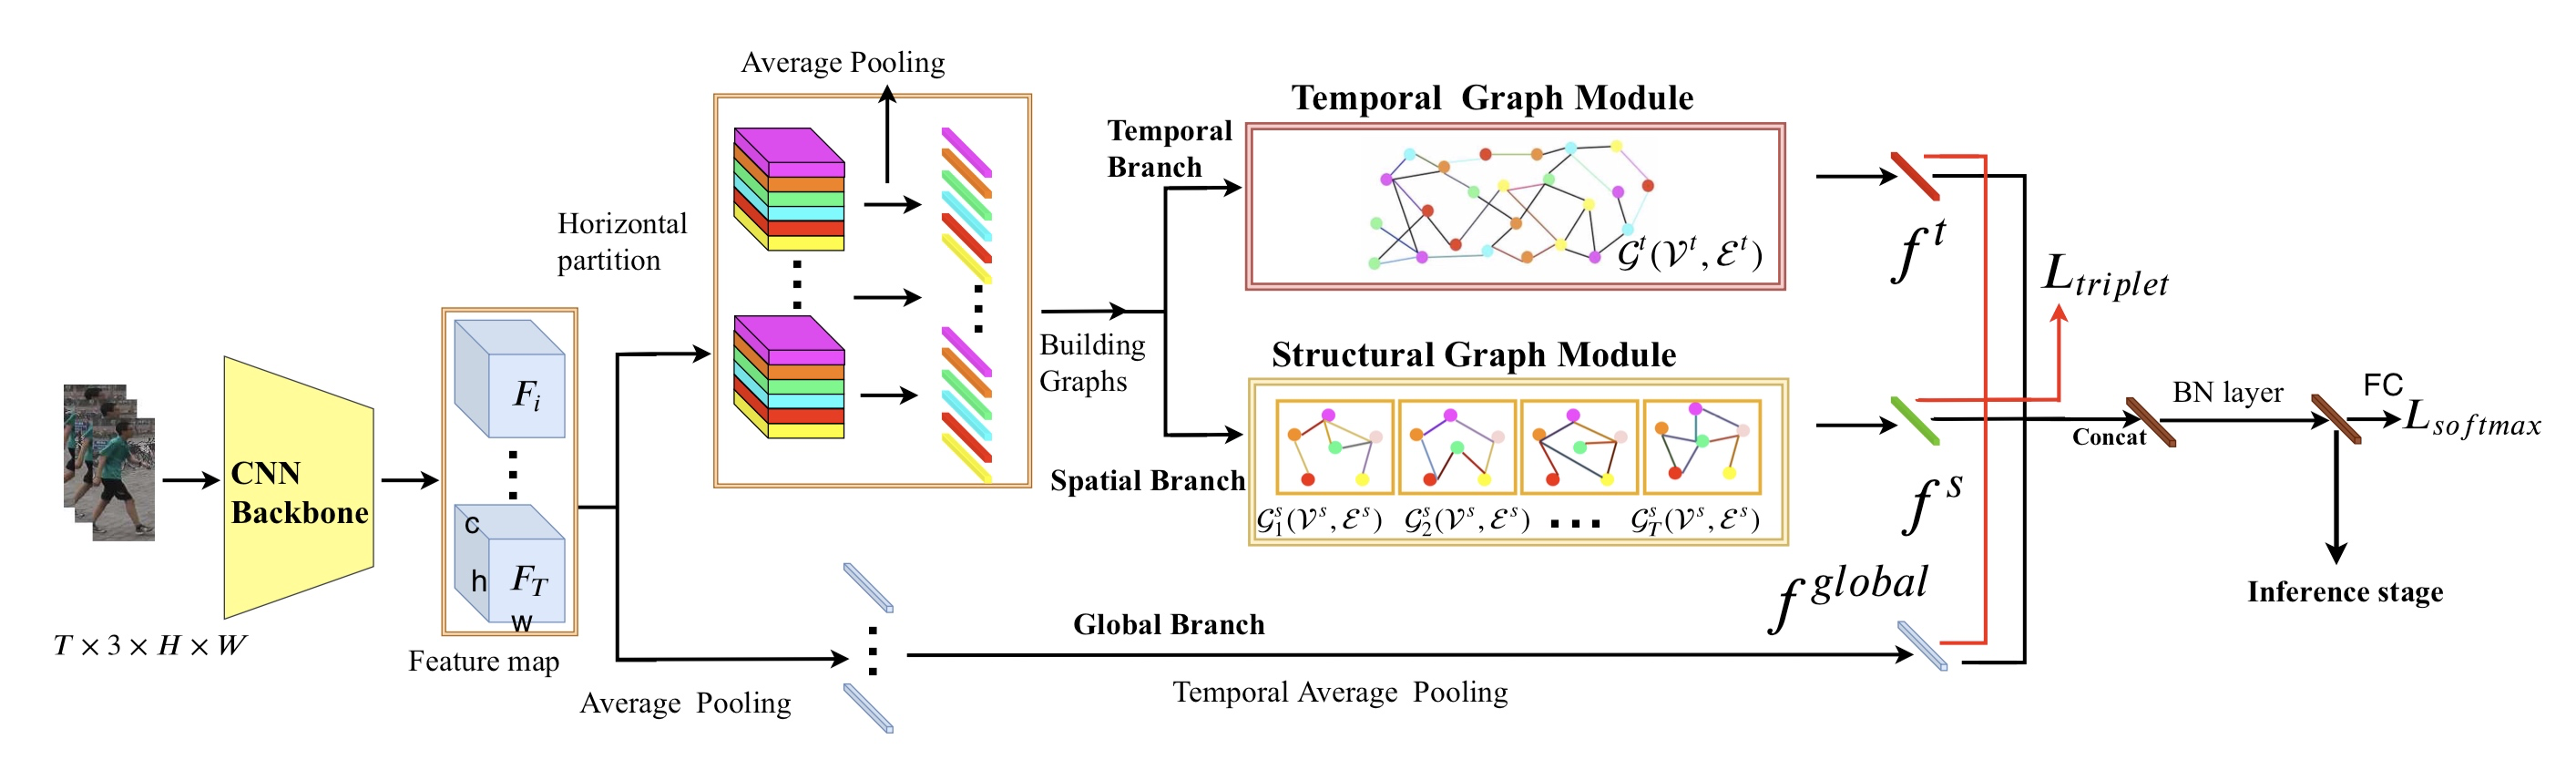

In [2]:
# dgl.function.copy_src（src，out）是一个边UDF，它使用源节点特征数据计算输出。用户需要指定源特征数据（src）的名称和输出名称（out）。
#   dgl.function.sum（msg，out）是一个节点UDF，它对节点邮箱中的消息进行求和。用户需要指定消息名称（msg）和输出名称（out）。
# 在这里，每个节点发送Embedding的时候不需要任何处理
#所以可以通过内置的copy_scr实现，out='m'表示发送到目的节点后目的节点的mailbox用m来标识这个消息是源节点的Embedding。
gcn_msg=fn.copy_src(src="h",out="m")
gcn_reduce=fn.sum(msg="m",out="h")#聚合邻居节点的特征

In [3]:
#定义节点的UDF apply_nodes  他是一个完全连接层
class NodeApplyModule(nn.Module):
    #初始化
    def __init__(self,in_feats,out_feats,activation):
        super(NodeApplyModule,self).__init__()
        self.linear=nn.Linear(in_feats,out_feats)
        self.activation=activation
    #前向传播
    def forward(self,node):
        h=self.linear(node.data["h"])
        if self.activation is not None:
            h=self.activation(h)
        return {"h":h}

In [11]:
# GCN本质上是在所有节点上执行消息传递，然后应用NodeApplyModule
class GCN(nn.Module):
    #初始化
    def __init__(self,in_feats,out_feats,activation):
        super(GCN,self).__init__()
        #调用全连接层模块
        self.apply_mod=NodeApplyModule(in_feats,out_feats,activation)
    #前向传播
    def forward(self,g,feature):
        g.ndata["h"]=feature#feature应该对应的整个图的特征矩阵
        g.update_all(gcn_msg,gcn_reduce)
        g.apply_nodes(func=self.apply_mod)#将更新操作应用到节点上
        
        return g.ndata.pop("h")

In [24]:
class SpatialGCN(nn.Module):
    def __init__(self,in_feats,out_feats,activation):
        super(SpatialGCN,self).__init__()
        self.gcn1 = GCN(in_feats,out_feats,F.relu)
        self.gcn2 = GCN(out_feats,7,None)
        
    def forward(self,g,features):
        x = self.gcn1(g,features)
        x = self.gcn2(g,x)

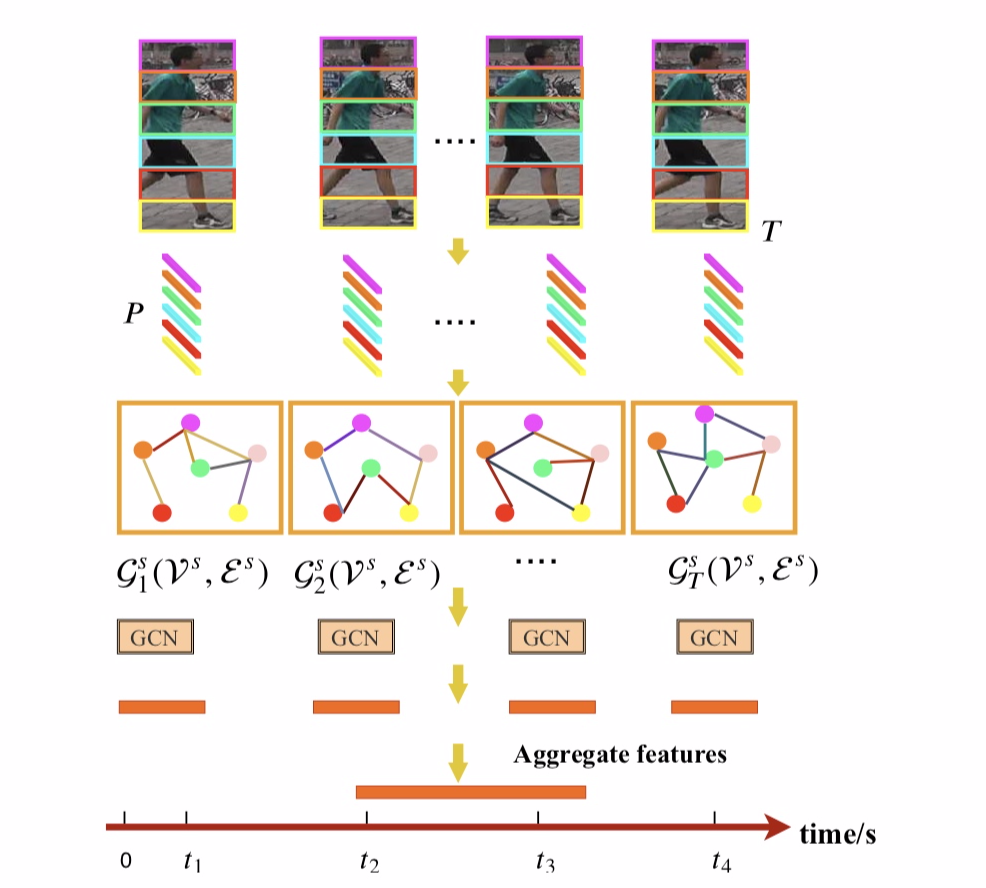

In [16]:

    
class TemporalGCN(nn.Module):
    def __init__(self,in_feats,out_feats,activation):
        super(TemporalGCN,self).__init__()
        self.gcn1 = GCN(in_feats,out_feats,F.relu)
        self.gcn2 = GCN(out_feats,16,F.relu)
        self.gcn3 = GCN(16,7,None)
        
    def forward(self,g,features):
        x = self.gcn1(g,features)
        x = self.gcn2(g,x)
        x = self.gcn3(g,x)

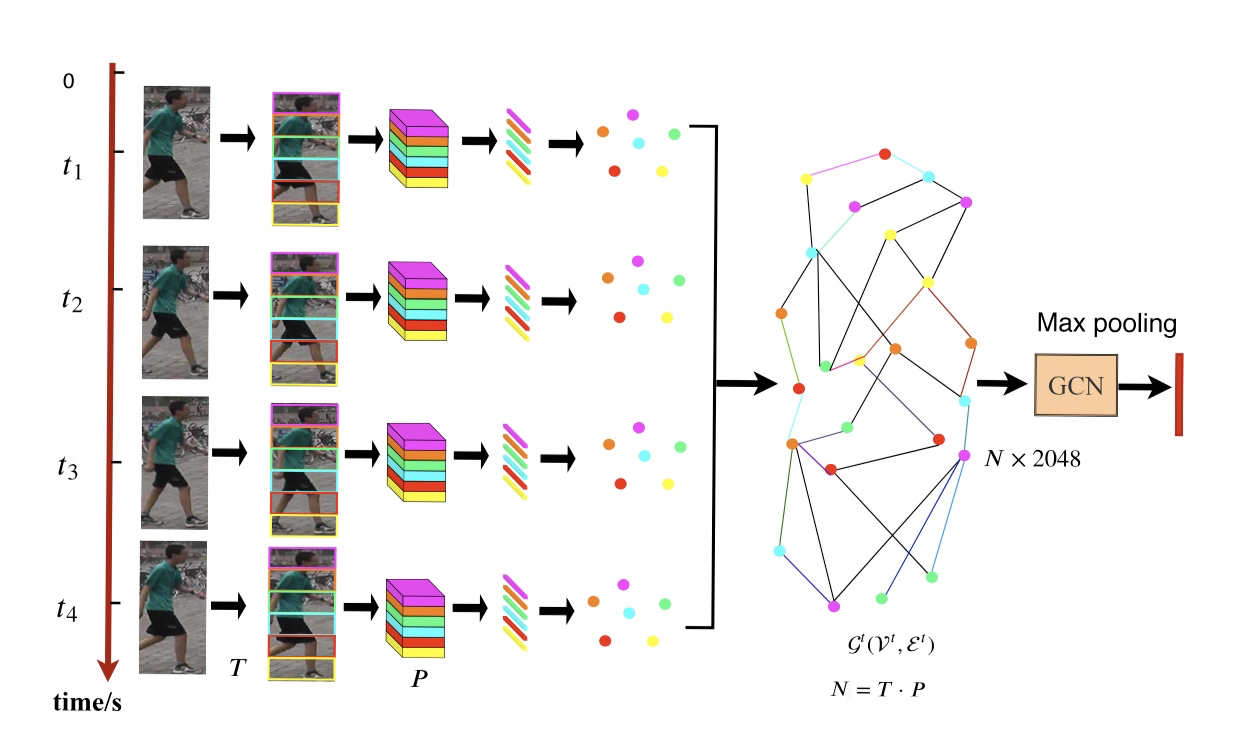

- CNN模型用的是在imagenet预训练后的ResNet50，并且最后一层必输设为1。
- 采用受限随机采样策略从每个视频中随机采样T=8帧。
- 把图片resize为256x128并且随机水平翻转。 模型训练800轮。
- 初始化学习率为0.0003，每200轮缩小十倍
- Adam优化器、16个身份为一个batch每个身份有四个追踪器tracklet,16 × 4 × 8 = 512 images。
- TGCN有3层、SGCN有2层 把每个feature map水平切分的P为4

In [20]:
class STGCN(nn.Module):
    def __init__(self,feature_map=None):
        super(STGCN,self).__init__()
        self.SpatialGCN=SpatialGCN(1433,16,F.relu)
        self.TemporalGCN=TemporalGCN(1433,128,F.relu)
        
    def forward(self,g,features):
        x_Spatial = SpatialGCN(g,features)
        x_Temporal= SpatialGCN(g,features)
        return x_Spatial,x_Temporal
    
stgcn=STGCN()
stgcn

STGCN(
  (SpatialGCN): SpatialGCN(
    (gcn1): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1433, out_features=16, bias=True)
      )
    )
    (gcn2): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=16, out_features=7, bias=True)
      )
    )
  )
  (TemporalGCN): TemporalGCN(
    (gcn1): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1433, out_features=128, bias=True)
      )
    )
    (gcn2): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=128, out_features=16, bias=True)
      )
    )
    (gcn3): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=16, out_features=7, bias=True)
      )
    )
  )
)

In [19]:
resnet34_other = resnet34_other()
resnet34_other

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 

In [23]:
# 基于imagenet的预训练处理
import os
model_weight_path = './resnet34-333f7ec4.pth'
assert os.path.exists(model_weight_path), "file {} does not exist.".format(model_weight_path)
missing_keys, unexpected_keys = resnet34_other.load_state_dict(torch.load(model_weight_path), strict=False)
# in_channel = resnet34_other.fc.in_features
# resnet34_other.fc = nn.Linear(in_channel,5)
# net.to(device)

class ReID(nn.Module):
    def __init__(self,num_classes,out_channel,image2Graph=None):
        super(ReID,self).__init__()
        self.resnet = resnet34_other(num_classes=num_classes)
        self.Average_pooling = nn.AdaptiveAvgPool2d((1,1))
        self.get_Graph=image2Graph  # 将resnet输出的feature map转化为图结构
        self.STGCN = STGCN()
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.linear = nn.Linear(num_classes)
        
    def forward(self,x):
        feature_map = self.resnet34_other(x)
        s,t = STGCN(feature_map)
        

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.gcn1 = GCN(1433,16,F.relu)
        self.gcn2 = GCN(16,7,None)
        
    def forward(self,g,features):
        x = self.gcn1(g,features)
        x = self.gcn2(g,x)
        return x
net = Net()
print(net)

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)


In [22]:
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_cora_data():
    data = citegrh.load_cora()#加载数据集
    features=torch. FloatTensor(data.features)#特征向量  张量的形式
    labels=torch.LongTensor(data.labels)#所属类别
    train_mask=torch.BoolTensor(data.train_mask)#那些参与训练
    test_mask=torch.BoolTensor(data.test_mask)#哪些是测试集
    g=data.graph
    g.remove_edges_from(nx.selfloop_edges(g))#删除自循环的边
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, train_mask, test_mask

In [23]:
#测试模型
def evaluate(model, g, features, labels, mask):
    model.eval()#会通知所有图层您处于评估模式
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)


In [24]:
import time
import numpy as np
g, features, labels, train_mask, test_mask = load_cora_data()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
dur = []

for epoch in range(50):
    if epoch>=3:
        t0 = time.time()
        
    net.train()
    logits = net(g,features)
    logp = F.log_softmax(logits,1)
    loss = F.nll_loss(logp[train_mask],labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch>=3:
        dur.append(time.time() - t0)
    acc = evaluate(net,g,features,labels,test_mask)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)))

Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


AttributeError: 'set' object has no attribute 'items'